### imports

In [1]:
import cv2
import numpy as np
from PIL import Image
import imutils

In [2]:
import matplotlib.pyplot as plt
import os
import keras

from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D, AveragePooling2D, average
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import Adadelta

from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, UpSampling2D
from keras.layers import Convolution2D, ZeroPadding2D, Embedding, LSTM, merge, Lambda, Deconvolution2D, Cropping2D

from keras.layers import ELU, ReLU
act = ReLU

from custom_models import *
from algo import *

Using TensorFlow backend.


In [3]:
from skimage.transform import resize

### function def

In [4]:
def read_input(path):
    x = cv2.imread(path)
    x = cv2.resize(x, (256, 256))
    b, g, r = cv2.split(x)
    x = cv2.merge((r, r, r))
    return x.reshape(256, 256, 3)/255.


def read_gt(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    return x/255.

### image loading and preprocessing

In [5]:
photoname = 'N-16-R'
path = 'test_img/'+photoname+'.png'
cup_path = 'test_img/'+photoname+'-Cup-Avg.png'
disc_path = 'test_img/'+photoname+'-Disc-Avg.png'

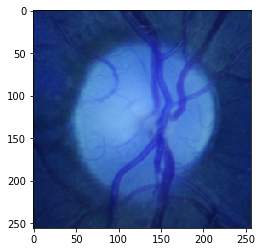

In [6]:
contour_img = np.array(Image.open(path))
img = cv2.imread(path)
img = cv2.resize(img, (256, 256))
b, g, r = cv2.split(img)
img_r = cv2.merge((r, r, r))/255.
true_cup = cv2.imread(cup_path, cv2.IMREAD_GRAYSCALE)
true_disc = cv2.imread(disc_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

### load weights

In [7]:
disc_model = get_unet(do=0.25, activation=act)
disc_model.load_weights('Models/ODSeg_best3.h5')

cup_model = get_unet1(do=0.2, activation=act)
# cup_model = load_model('Models/CupSeg_3.h5')
cup_model.load_weights('Models/CupSeg_3.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Disc prediction

In [8]:
disc_pred = disc_model.predict(np.array([img_r]))
disc_pred = np.clip(disc_pred, 0, 1)
pred_disc = (disc_pred[0, :, :, 0]>0.5).astype(int)
# pred_disc = resize(pred_disc, (512, 512))
pred_disc = 255*pred_disc#.*(pred_disc - np.min(pred_disc))/(np.max(pred_disc)-np.min(pred_disc))
cv2.imwrite('temp_disc.png', pred_disc)

True

In [9]:
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(disc, cmap='gray')

Text(0.5, 1.0, 'True disc')

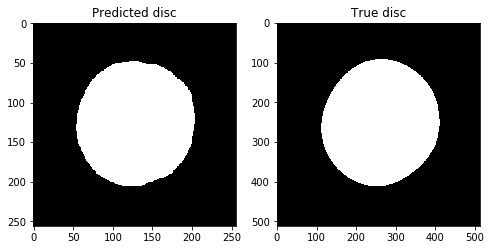

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(pred_disc, cmap='gray')
ax1.set_title('Predicted disc')
ax2.imshow(true_disc, cmap='gray')
ax2.set_title('True disc')

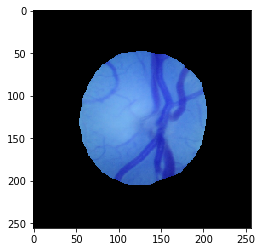

In [11]:
masked = cv2.bitwise_and(img, img, mask=disc)

plt.imshow(masked)
plt.show()

mb, mg, mr = cv2.split(masked)
masked = cv2.merge((mb, mb, mb))

### cup prediction

In [12]:
cup_pred = cup_model.predict(np.array([masked]))
pred_cup = (cup_pred[0, :, :, 0]>0.5).astype(int)
pred_cup = cv2.bilateralFilter(cup_pred[0, :, :, 0],10,40,20)
pred_cup = (pred_cup>0.5).astype(int)
pred_cup = resize(pred_cup, (512, 512))
pred_cup = 255.*(pred_cup - np.min(pred_cup))/(np.max(pred_cup)-np.min(pred_cup))
cv2.imwrite('temp_cup.png', pred_cup)

/home/anuj1402/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


True

Text(0.5, 1.0, 'True cup')

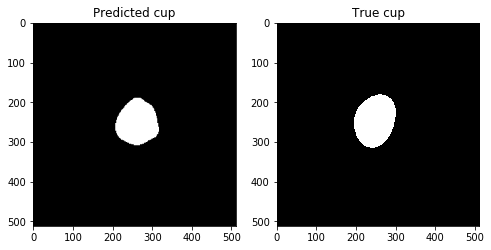

In [13]:
cup = cv2.imread('temp_cup.png', cv2.IMREAD_GRAYSCALE)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(cup, cmap='gray')
ax2.imshow(true_cup, cmap='gray')
ax1.set_title('Predicted cup')
ax2.set_title('True cup')

In [14]:
disc = resize(disc, (512, 512))
cv2.imwrite('temp_disc.png', disc)
disc = cv2.imread('temp_disc.png', cv2.IMREAD_GRAYSCALE)
(thresh, disc) = cv2.threshold(disc, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite('temp_disc.png', disc)
(thresh, cup) = cv2.threshold(cup, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

In [15]:
cup_img = Image.open('temp_cup.png')
disc_img = Image.open('temp_disc.png')

# ISNT

In [16]:
isnt, cup_dias = ISNT(cup, disc, 'r')
print("\nI : {}\nS : {}\nN : {}\nT : {}".format(isnt[0], isnt[1], isnt[2], isnt[3]))

if isnt[0] > isnt[1] > isnt[2] > isnt[3] :
    print("\nNot Suspicious")
else:
    print("\nSuspicious")


I : 104
S : 92
N : 100
T : 90

Suspicious


# DDLS

In [17]:
ddls, disc_dias, minrim, minang, minind = DDLS(cup_img, disc_img, 5)
print("DDLS : %.5f" % ddls)

Minimum Rim Width : 86
Disc Diameter : 320 

DDLS : 0.26875


# CDR

In [18]:
ver_cdr = cup_dias[0]/disc_dias[0]
print("Vertical CDR : %.5f" % ver_cdr)

hor_cdr = cup_dias[1]/disc_dias[1]
print("Horizontal CDR : %.5f" % hor_cdr)

Vertical CDR : 0.37975
Horizontal CDR : 0.36667


## plots

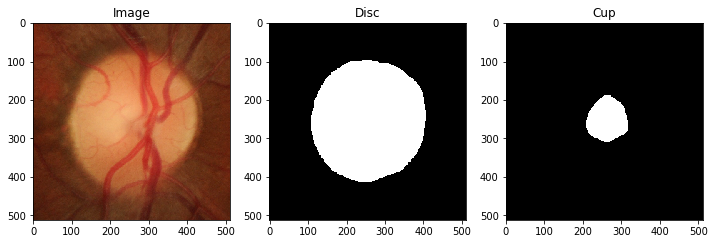

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))
ax1.set_title("Image")
ax1.imshow(contour_img)
ax2.set_title("Disc")
ax2.imshow(disc, cmap='gray')
ax3.set_title("Cup")
ax3.imshow(cup, cmap='gray')

### contour plot

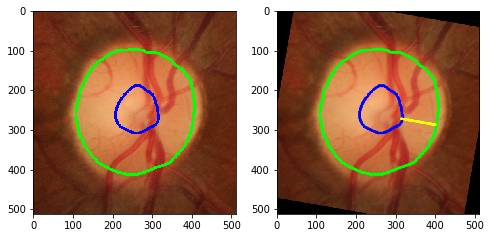

In [20]:
ret,thresh_disc = cv2.threshold(disc,127,255,0)
image_contour, contours_disc, hierarchy = cv2.findContours(thresh_disc , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
bound_disc = cv2.drawContours(contour_img, contours_disc, 0, (0,255,0), 5)

ret,thresh_cup = cv2.threshold(cup,127,255,0)
image, contours_cup, hierarchy = cv2.findContours(thresh_cup,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
bound = cv2.drawContours(bound_disc, contours_cup, 0, (0,0,255), 5)

disc = imutils.rotate(disc, minang)
d_b = 0
for i in range(disc.shape[0]):
    if disc[i][minind] == 255:
        break
    else:
        d_b += 1
        
rotated = imutils.rotate(bound, minang)
lined = cv2.line(rotated, (minind, d_b+1), (minind, d_b + minrim+3), (255, 255, 0), 5)

rotated = imutils.rotate(lined, 360-minang)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(bound)
ax2.imshow(rotated)

In [21]:
os.remove('temp_cup.png')
os.remove('temp_disc.png')